# pydca demo

## MSA Trimming
Here we show how to use pydca as a library. We start with by importing pydca or selected modules within pydca.

In [1]:
"""pydca demo

Author: Mehari B. Zerihun
"""

# import pydca modules
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca import dca_utilities
import os
import pandas as pd
import numpy as np

print(os.getcwd())

pfam_id = 'PF00186'


msa_npy_file = '/home/eclay/Pfam-A.full/%s/msa.npy' % pfam_id # Hurricane Location
msa_fa_file  = '/home/eclay/Pfam-A.full/%s/msa.fa' % pfam_id # Hurricane Location
pdb_ref_file = '/home/eclay/Pfam-A.full/%s/pdb_refs.npy' % pfam_id # Hurricane Location

DCA_ER_dir = '/home/evan/PycharmProjects/DCA_ER/'
msa_npy_file = '/home/evan/PycharmProjects/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/home/evan/PycharmProjects/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/home/evan/PycharmProjects/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id

DCA_ER_dir = '/home/ecresswell/DCA_ER/'
msa_npy_file = '/home/ecresswell/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/home/ecresswell/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/home/ecresswell/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id

# os.chdir('/home/evan/PycharmProjects/DCA_ER')
# os.chdir('/home/eclay/DCA_ER') # Hurrican Location
os.chdir('/home/ecresswell/DCA_ER')
ipdb = 0
from ecc_tools import npy2fa
msa_outfile, ref_outfile = npy2fa(pfam_id, msa_npy_file, pdb_ref_file=pdb_ref_file, ipdb=ipdb)


/home/ecresswell/DCA_ER
Reference sequence (tpdb, s_ipdb) is sequence # 69


In [2]:
rna_msa_file = '/home/evan/pydca/examples/MSA_RF00167.fa'
rna_refseq_file = '/home/evan/pydca/examples/ref_RF00167.fa'
rna_msa_file = '/home/eclay/DCA_ER/pydca/examples/MSA_RF00167.fa' # Hurricane location
rna_refseq_file = '/home/eclay/DCA_ER/pydca/examples/ref_RF00167.fa' # Hurricane location

# create MSATrimmer instance 
trimmer = msa_trimmer.MSATrimmer(
    str(msa_outfile), biomolecule='protein', 
    refseq_file=str(ref_outfile),
)

trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)

#write trimmed msa to file in FASTA format
trimmed_data_outfile = 'MSA_RF00167_Trimmed.fa'
trimmed_data_outfile = 'MSA_%s_Trimmed.fa' % pfam_id
with open(trimmed_data_outfile, 'w') as fh:
    for seqid, seq in trimmed_data:
        fh.write('>{}\n{}\n'.format(seqid, seq))
        

In the above, we have imported pydca or selected modules from pydca. Then we defined two variables `rna_msa_file` and `rna_refseq_file` that contain paths to an RNA MSA file and its reference sequence, respectively. Following that we created an MSATrimmer instance which enabled us to trim the MSA file. Finally, we write the trimmed MSA data to an output file `MSA_RF00167_Trimmed.fa` in FASTA format. To trim protein sequences we just need to change `biomolecule='rna'`  to `biomolecule='protein'` and provide the respective MSA and reference sequence files. Next we carry out DCA computations using the trimmed MSA saved in `MSA_RF00167_Trimmed.fa`

## DCA Computation Using Pseudolikelihood Maximization Algorithm (plmDCA)

In [3]:
# Compute DCA scores using Pseudolikelihood maximization algorithm

plmdca_inst = plmdca.PlmDCA(
    trimmed_data_outfile,
    'protein',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads =6,
    max_iterations = 500,
)
    
plm_out_file = '%s%s_di_pydca_plm.npy' % (DCA_ER_dir, pfam_id)

if os.path.exists(plm_out_file):
    plmdca_FN_APC = np.load(plm_out_file)
else:
    # compute DCA scores summarized by Frobenius norm and average product corrected
    plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()

In the above, we created a PlmDCA instance `plmdca_inst`  for RNA. Notice that we used the trimmed MSA data we obtained before.  We also set the values of optional parameters. The optional parameters `num_threads` is set to 10. If `pydca` is installed without OpenMP support, we cannot set the number of threads more than one. Finally we computed the DCA scores from the Frobenius norm of the couplings by calling the `compute_sorted_FN_APC()` method on `plmdca_inst`. This action returns the average product corrected (APC) DCA scores. Let us print the top five site pairs and their DCA scores.

In [4]:
for site_pair, score in plmdca_FN_APC[:5]:
    print(site_pair, score)
    
# Save the scores for future use/comparison
np.save(plm_out_file, plmdca_FN_APC)

(12, 122) 2.4129321678851983
(57, 73) 2.3337297580996625
(15, 16) 2.2252069618464456
(9, 117) 2.081029507290176
(35, 55) 1.9994938784236451


We have displayed the top five site pairs ranked by their DCA scores. The first column is a tuple of site-pairs and the second column contains the DCA scores obtained from the Frobenius norm of the couplings. Note that the site pairs are arranged in the form (i, j) such that j > i.

## DCA Computation Using Mean-Field Algorithm (mfDCA)

In [5]:
#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    trimmed_data_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)

mf_out_file = '%s%s_di_pydca_mf.npy' % (DCA_ER_dir, pfam_id)

if os.path.exists(mf_out_file):
    mfdca_FN_APC = np.load(mf_out_file)
else:
    # Compute average product corrected Frobenius norm of the couplings
    mfdca_FN_APC = mfdca_inst.compute_sorted_FN_APC()

In the above, we created a mean-field DCA instance `mfdca_inst`. We set the optional parameters `pseudocount` and `seqid` to be `0.5` and `0.8`, respectively. Like in the plmDCA we computed the DCA scores from the Frobenius norm of the couplings and average product corrected. using `compute_sorted_FN_APC` method of `mfdca_inst`. Let us print the top five ranked site pairs.

In [6]:
for site_pair, score in mfdca_FN_APC[:5]:
    print(site_pair, score)
    
# Save the scores for future use/comparison
np.save(mf_out_file, mfdca_FN_APC)

(12, 122) 6.138025173005573
(5, 7) 5.621116744970361
(57, 73) 5.261730265149883
(8, 12) 5.186876257484779
(30, 95) 4.9399639198804985


## Plotting Contact Map and True Positive Rates

Next  we plot the contact map and true positive rates of DCA scores computed using the two methods (plmDCA and mfDCA)
### Contact Map and True Positive Rate for PlmDCA Scores

In [7]:
# ---------------------- We need to get pdb information for the contact visualizer --------------------------#
# Define pdb-references for Protein Family

os.chdir(DCA_ER_dir)

# Set DCA_ER directory
DCA_dir = os.getcwd()

pdb = np.load(pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
pdb_df.head()
pdb_id = pdb_df.iloc[ipdb]['pdb_id']
pdb_chain = pdb_df.iloc[ipdb]['chain']
# -----------------------------------------------------------------------------------------------------------#



plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = ref_outfile,
    sorted_dca_scores = plmdca_FN_APC,
    linear_dist = 4,
    contact_dist = 5.0,
)

number of pdb structures: 372


Now we have created an instance of `DCAVisualizer`. It takes the type of biomolecule ('rna') , PDB chain ('x'), PDB ID ('1y26'). In addition we have specified reference sequence file, list of sorted DCA scores, linear distance and contact distnace.  When we execute the above cell we see a warning `You didn't supply RNA secondary structure file`. Since supplying an RNA secondary structure file is optional, we can ignore the warning. Next we plot the contact map and true postive rates.

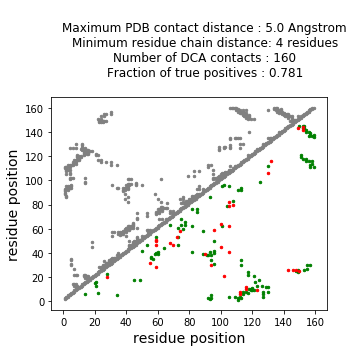

In [8]:
contact_map_data = plmdca_visualizer.plot_contact_map()

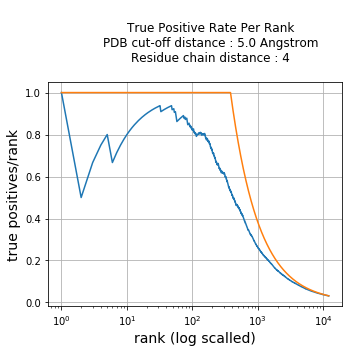

In [9]:
tp_rate_data = plmdca_visualizer.plot_true_positive_rates()

### Contact Map and True Positive Rate for Mean-Field DCA Scores

Like DCA scores computed using the plmDCA algorithm, we can visualize contact map and true positive rates for mfDCA computed DCA scores as shown below.

In [10]:
mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = ref_outfile,
    sorted_dca_scores = mfdca_FN_APC,
    linear_dist = 4,
    contact_dist = 8.0,
)

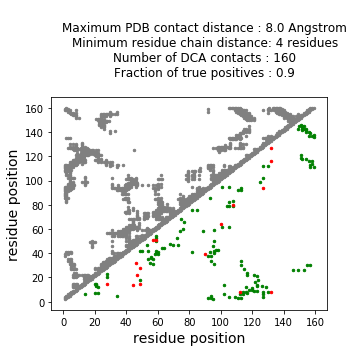

In [11]:
contact_map_data = mfdca_visualizer.plot_contact_map()

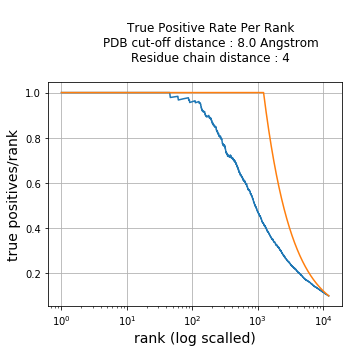

In [12]:
tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

### Computing Fields and Couplings

We can also compute the fields and couplings of the global probability model. That is the $h_{i}$s and $J_{ij}$s in the expression $P(a_{1}, a_{2}, ..., a_{L}) =\frac{1}{Z}\exp(\sum_{i<j} J_{ij}(a_{i}, a_{j}) + \sum_{i} h_{i}(a_{i}))$. In pydca these parameters can be computed using either the mean-field DCA algorithm or the pseudolikelihood maximization DCA algorithm.

In [13]:
fields_plm, couplings_plm = plmdca_inst.compute_params(ranked_by='di_apc', num_site_pairs=100)


Or using the mean-field algorithm as:

In [14]:
fields_mf, couplings_mf = mfdca_inst.compute_params(ranked_by='fn_apc', num_site_pairs=200)

When we compute the fields and couplings, we can specify a ranking method for the couplings so that the site pairs for the couplings are ordered according to the ranking method.  In the above examples, we used 'di_apc' for the PlmDCA and 'fn_apc' for the mfDCA algorithms. 'di_apc' stands for the ranking method is average product corrected direct information scores, whereas 'fn_apc' implies average corrected Frobenius norm.